# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [98]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [4]:
feature_names = []
datapath = 'E:\GitHub\Fall2017-Section2'
with open(datapath + '\Data\mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open(datapath + '\Data\mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

Total variance: 11.3693957912

Number of components | Variance explained
                   1 | 0.164
                   2 | 0.297
                   3 | 0.399
                   4 | 0.470
                   5 | 0.508
                   6 | 0.545
                   7 | 0.576
                   8 | 0.604
                   9 | 0.630
                  10 | 0.652
                  11 | 0.673
                  12 | 0.691
                  13 | 0.709
                  14 | 0.726
                  15 | 0.741
                  16 | 0.756
                  17 | 0.770
                  18 | 0.784
                  19 | 0.798
                  20 | 0.809
                  21 | 0.820
                  22 | 0.830
                  23 | 0.841
                  24 | 0.851
                  25 | 0.860
                  26 | 0.868
                  27 | 0.876
                  28 | 0.884
                  29 | 0.892
                  30 | 0.899
                  31 | 0.905
                  32 | 0.911

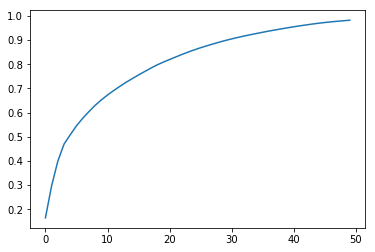

In [42]:
def P1():
### STUDENT START ###

    # Covariance of the training data
    covar = pd.DataFrame(train_data).cov()
    #print covar.shape
    #print covar.head()

    # Total variance is the sum along the diagonal of the covariance array
    print("Total variance: {}\n".format(np.trace(covar)))

    # Run Principal Components Analysis on the data
    pca = PCA()
    train_transformed = pca.fit_transform(train_data)
    #print X_transformed.shape
    #new_covar = np.round(pd.DataFrame(X_transformed).cov(), 10)
    #print np.trace(new_covar)
    
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    print("Number of components | Variance explained")
    for k in range(50):
        print("{:20} | {:5.3f}".format(k+1,var_explained[k]))
    plt.plot(var_explained[:50])
    
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

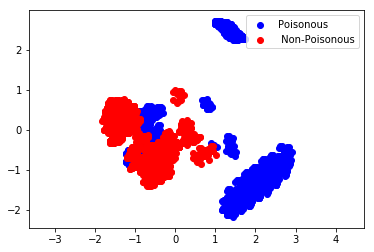

In [58]:
def P2():
### STUDENT START ###
    pca2 = PCA(n_components=2)
    train_reduced = pca2.fit_transform(train_data)
    #print train_reduced.shape
    #print train_reduced
    
    train_reduced_poisonous = train_reduced[train_labels == 1]
    train_reduced_nonpoisonous = train_reduced[train_labels == 0]
    
    plt.scatter(train_reduced_poisonous[:,0],train_reduced_poisonous[:,1], label='Poisonous', c='blue')
    plt.scatter(train_reduced_nonpoisonous[:,0],train_reduced_nonpoisonous[:,1], label=' Non-Poisonous', c='red')
    plt.legend()
    plt.axis("equal")
    plt.show
    
### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

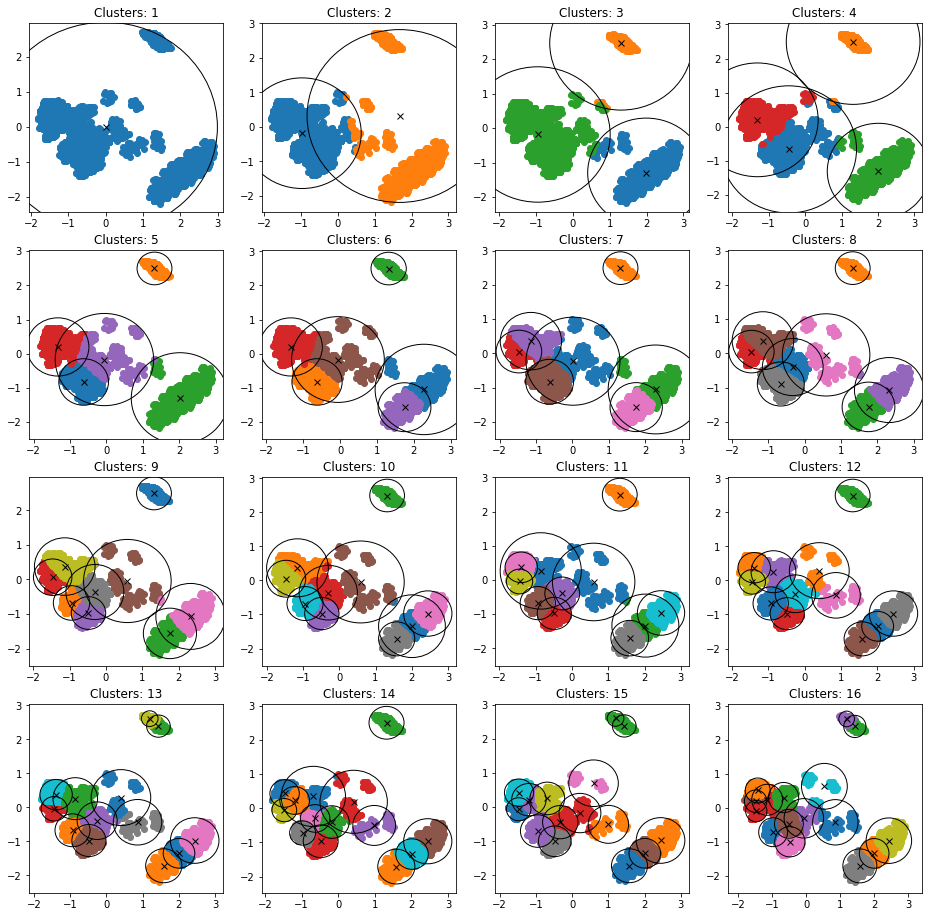

In [110]:
def P3():
### STUDENT START ###

    pca2 = PCA(n_components=2)
    train_reduced = pca2.fit_transform(train_data)
    
    # Run KMeans with [1,16] clusters over the 2d projected data
    fig = plt.figure(figsize=(16, 16))
    fnum = 0
    for k in range(1,17):
        km = KMeans(n_clusters=k)
        km.fit(train_reduced)
        
        # Cluster centers
        centers = km.cluster_centers_
        #print centers.shape
        
        # Data in clusters
        labels = km.predict(train_reduced)
        #print labels.shape
        
        # Distance to cluster center
        dists = km.transform(train_reduced)
        #print dists.shape
                
        # plot a circle that goes through the most distant point assigned to each cluster 
        fnum += 1
        for i in range(k):
            cluster_members = labels == i
            cluster_center = centers[i]
            #print cluster_center.shape
            #print cluster_center
            cluster_dists = dists[cluster_members, i]
            max_dist = cluster_dists.argmax()
            radius = cluster_dists[max_dist]
            #print radius 
            ax = fig.add_subplot(4,4,fnum)
            ax.add_artist(plt.Circle((cluster_center[0], cluster_center[1]), radius, fill=False))
            ax.plot(cluster_center[0], cluster_center[1], 'kx')
            ax.scatter(train_reduced[cluster_members,0],train_reduced[cluster_members,1])
            ax.set_title('Clusters: ' + str(k))
    
    plt.axis("equal")
    plt.show()

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

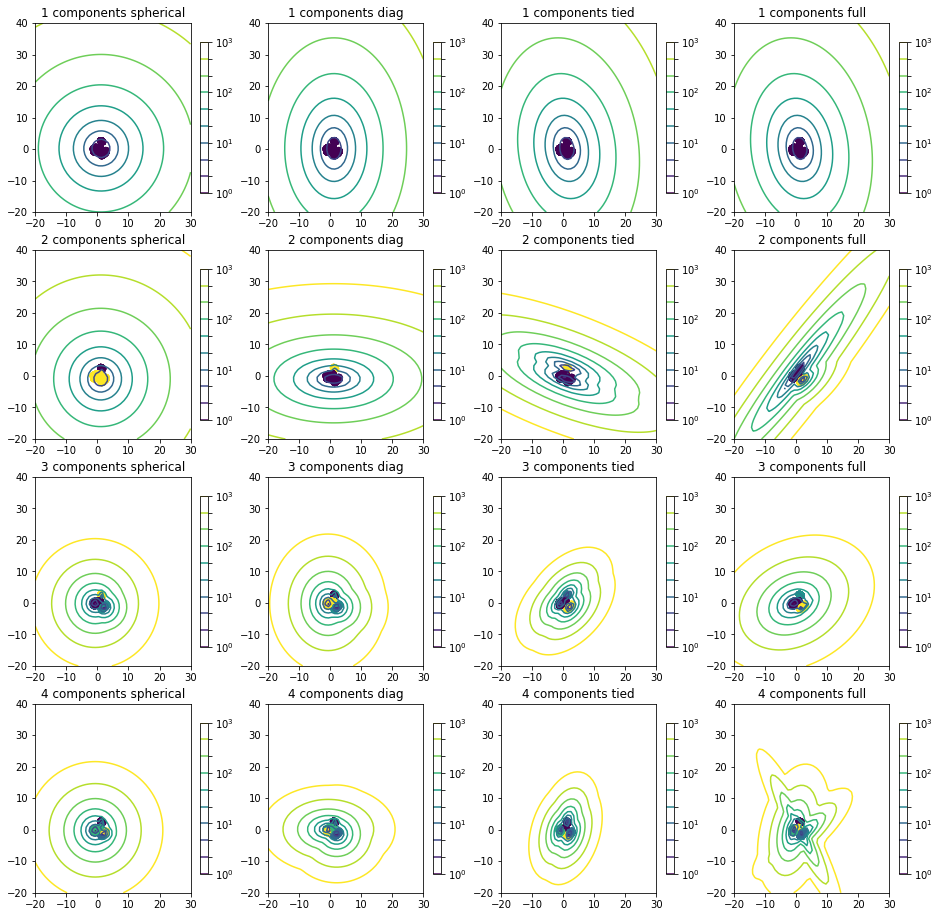

In [115]:
def P4():
### STUDENT START ###

    # Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. 
    pca2 = PCA(n_components=2)
    train_reduced = pca2.fit_transform(train_data)  
    train_reduced_poisonous = train_reduced[train_labels == 1]
    
    # Vary the number of mixture components from 1-4 
    # and the covariance matrix type ('spherical', 'diag', 'tied', 'full')
    comps = [1, 2, 3, 4]
    structures = ['spherical', 'diag', 'tied', 'full']
    fig = plt.figure(figsize=(16, 16))
    fnum = 0
    for comp in comps:
        for structure in structures:
            fnum += 1
            gm_mod = GaussianMixture(n_components = comp, covariance_type = structure)
            gm_mod.fit(train_reduced_poisonous)
            labels = gm_mod.predict(train_reduced_poisonous)
            ax = fig.add_subplot(4,4,fnum)
            ax.scatter(train_reduced_poisonous[:, 0], train_reduced_poisonous[:, 1], c=labels)
            
            # Plot the estimated density contours 
            # display predicted scores by the model as a contour plot
            x = np.linspace(-20., 30.)
            y = np.linspace(-20., 40.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm_mod.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            ax.set_title(str(comp) + ' components ' + structure)
            CB = plt.colorbar(CS, shrink=0.8, extend='both')

            #plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.axis('tight')
    plt.show()


### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [150]:
def P5():
### STUDENT START ###

    # 2d projected data
    pca2 = PCA(n_components=2)
    train_reduced = pca2.fit_transform(train_data)  
    train_reduced_poisonous = train_reduced[train_labels == 1]
    train_reduced_nonpoisonous = train_reduced[train_labels == 0]

    # 4-component full covariance GMM, one for positive (poisonous) and one for negative (nonpoisonous)
    gm_mod_poisonous = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 0)
    gm_mod_nonpoisonous = GaussianMixture(n_components = 4, covariance_type = 'full', random_state = 0)
    
    # Fit one for the positive examples and one for the negative examples
    gm_mod_poisonous.fit(train_reduced_poisonous)
    gm_mod_nonpoisonous.fit(train_reduced_nonpoisonous)
    
    # Transform the test data
    test_reduced = pca2.transform(test_data)

    # Predict the test examples by choosing the label for which the model gives a larger probability    
    # Score_samples returns the log probabilities which are negative 
    poisonous_score = gm_mod_poisonous.score_samples(test_reduced)
    nonpoisonous_score = gm_mod_nonpoisonous.score_samples(test_reduced)
        
    #print poisonous_score.shape
    #print poisonous_score
    #print nonpoisonous_score.shape
    #print nonpoisonous_score
    
    test_predict = np.array([1 if x>y else 0 for x,y in zip(poisonous_score,nonpoisonous_score)])
    #print test_predict
    #print test_labels
    #print test_labels.shape[0]
    
    # What is the accuracy?
    correct = np.array([1 if x==y else 0 for x,y in zip(test_predict,test_labels)])
    num_correct = correct.sum()
    #print correct
    #print num_correct
    accuracy = float(num_correct)/float(test_labels.shape[0])
    print("Accuracy: {:5.3f}".format(accuracy))
    
### STUDENT END ###

P5()

Accuracy: 0.950


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [188]:
def P6():
### STUDENT START ###

    # Use no more than 50 parameters
    max_params = 50
    
    # Number of classes (poisonous and nonpoisonous)
    classes = 2

    # GMM_comp: Number of Gaussian components
    # pca_comp: Number of PCA components or dimensions
    # Covariance type  = [‘full’, ‘tied’, ‘diag’, ‘spherical’]
    
    # Pass the number of PCA and GMM components and structure then do all the work from P5 to output accuracy
    def dowork(pca_components, GMM_components, structure):
        accuracy = 0
        pca = PCA(n_components=pca_components)
        train_reduced = pca.fit_transform(train_data)  
        train_reduced_poisonous = train_reduced[train_labels == 1]
        train_reduced_nonpoisonous = train_reduced[train_labels == 0]
        gm_mod_poisonous = GaussianMixture(n_components = GMM_components, covariance_type = structure, random_state = 0)
        gm_mod_nonpoisonous = GaussianMixture(n_components = GMM_components, covariance_type = structure, random_state = 0)
        gm_mod_poisonous.fit(train_reduced_poisonous)
        gm_mod_nonpoisonous.fit(train_reduced_nonpoisonous)
        test_reduced = pca.transform(test_data)
        poisonous_score = gm_mod_poisonous.score_samples(test_reduced)
        nonpoisonous_score = gm_mod_nonpoisonous.score_samples(test_reduced)
        test_predict = np.array([1 if x>y else 0 for x,y in zip(poisonous_score,nonpoisonous_score)])
        correct = np.array([1 if x==y else 0 for x,y in zip(test_predict,test_labels)])
        num_correct = correct.sum()
        accuracy = float(num_correct)/float(test_labels.shape[0])
        return accuracy    
    
    # diagonal
    # params = ((covar_matrix_params + mean_vector_params) * GMM_comp) * classes
    # covar_matrix_params = pca_comp
    # mean_vector_params = pca_comp
    # params = ((pca_comp + pca_comp) * GMM_comp) * classes
    accuracies_diag = []
    GMM_comp_max = int(max_params / (2 * classes))
    for GMM_comp in range(1,GMM_comp_max+1):
        pca_comp = 1
        while (((pca_comp + pca_comp) * GMM_comp) * classes <= max_params):
            a = dowork(pca_comp, GMM_comp, 'diag')
            accuracies_diag.append([GMM_comp,pca_comp,((pca_comp + pca_comp) * GMM_comp) * classes, a])
            #print("GMM_comp: {} pca_comp: {} params: {} accuracy: {}".format(GMM_comp, pca_comp, ((pca_comp + pca_comp) * GMM_comp) * classes, a))
            pca_comp += 1            
    # Get the parameters for the maximum accuracy
    accuracies_diag_arr = np.array(accuracies_diag)
    max_index_diag = np.argmax(accuracies_diag_arr[:,3])
    accuracies_diag_max = accuracies_diag_arr[max_index_diag]
    print("Structure: diag        GMM_comp: {}   pca_comp: {}   params: {}   accuracy: {}".format(int(accuracies_diag_max[0]), int(accuracies_diag_max[1]), int(accuracies_diag_max[2]), accuracies_diag_max[3]))

    # full 
    # params = ((covar_matrix_params + mean_vector_params) * GMM_comp) * classes
    # the number of unique off-diagonal elements in symmetric matrix plus the number of diagonal elements
    # covar_matrix_params = (pca_comp*pca_comp - pca_comp)/2 + pca_comp
    # mean_vector_params = pca_comp
    # params = (((pca_comp*pca_comp - pca_comp)/2 + 2*pca_comp) * GMM_comp) * classes
    accuracies_full = []
    GMM_comp_max = int(max_params / (2 * classes))
    for GMM_comp in range(1,GMM_comp_max+1):
        pca_comp = 1
        while ((((pca_comp*pca_comp - pca_comp)/2 + 2*pca_comp) * GMM_comp) * classes <= max_params):
            a = dowork(pca_comp, GMM_comp, 'full')
            accuracies_full.append([GMM_comp,pca_comp,(((pca_comp*pca_comp - pca_comp)/2 + 2*pca_comp) * GMM_comp) * classes, a])
            #print("GMM_comp: {} pca_comp: {} params: {} accuracy: {}".format(GMM_comp, pca_comp, (((pca_comp*pca_comp - pca_comp)/2 + 2*pca_comp) * GMM_comp) * classes, a))
            pca_comp += 1            
    # Get the parameters for the maximum accuracy
    accuracies_full_arr = np.array(accuracies_full)
    max_index_full = np.argmax(accuracies_full_arr[:,3])
    accuracies_full_max = accuracies_full_arr[max_index_full]
    print("Structure: full        GMM_comp: {}   pca_comp: {}   params: {}   accuracy: {}".format(int(accuracies_full_max[0]), int(accuracies_full_max[1]), int(accuracies_full_max[2]), accuracies_full_max[3]))

    # spherical
    # params = ((covar_matrix_params + mean_vector_params) * GMM_comp) * classes
    # covar_matrix_params = 1
    # mean_vector_params = pca_comp
    # params = ((pca_comp + 1) * GMM_comp) * classes
    accuracies_spherical = []
    GMM_comp_max = int(max_params / (2 * classes))
    for GMM_comp in range(1,GMM_comp_max+1):
        pca_comp = 1
        while (((pca_comp + 1) * GMM_comp) * classes <= max_params):
            a = dowork(pca_comp, GMM_comp, 'spherical')
            accuracies_spherical.append([GMM_comp,pca_comp,((pca_comp + 1) * GMM_comp) * classes, a])
            #print("GMM_comp: {} pca_comp: {} params: {} accuracy: {}".format(GMM_comp, pca_comp, ((pca_comp + 1) * GMM_comp) * classes, a))
            pca_comp += 1            
    # Get the parameters for the maximum accuracy
    accuracies_spherical_arr = np.array(accuracies_spherical)
    max_index_spherical = np.argmax(accuracies_spherical_arr[:,3])
    accuracies_spherical_max = accuracies_spherical_arr[max_index_spherical]
    print("Structure: spherical   GMM_comp: {}   pca_comp: {}   params: {}   accuracy: {}".format(int(accuracies_spherical_max[0]), int(accuracies_spherical_max[1]), int(accuracies_spherical_max[2]), accuracies_spherical_max[3]))

    # tied
    # params = (covar_matrix_params + (mean_vector_params * GMM_comp)) * classes
    # covar_matrix_params = (pca_comp*pca_comp - pca_comp)/2 + pca_comp
    # mean_vector_params = pca_comp
    # params = ((pca_comp*pca_comp - pca_comp)/2 + pca_comp + (pca_comp * GMM_comp)) * classes
    accuracies_tied = []
    GMM_comp_max = int((max_params / classes) - 1)
    for GMM_comp in range(1,GMM_comp_max+1):
        pca_comp = 1
        while (((pca_comp*pca_comp - pca_comp)/2 + pca_comp + (pca_comp * GMM_comp)) * classes <= max_params):
            a = dowork(pca_comp, GMM_comp, 'tied')
            accuracies_tied.append([GMM_comp,pca_comp,((pca_comp*pca_comp - pca_comp)/2 + pca_comp + (pca_comp * GMM_comp)) * classes, a])
            #print("GMM_comp: {} pca_comp: {} params: {} accuracy: {}".format(GMM_comp, pca_comp, ((pca_comp*pca_comp - pca_comp)/2 + pca_comp + (pca_comp * GMM_comp)) * classes, a))
            pca_comp += 1            
    # Get the parameters for the maximum accuracy
    accuracies_tied_arr = np.array(accuracies_tied)
    max_index_tied = np.argmax(accuracies_tied_arr[:,3])
    accuracies_tied_max = accuracies_tied_arr[max_index_tied]
    print("Structure: tied        GMM_comp: {}   pca_comp: {}   params: {}   accuracy: {}".format(int(accuracies_tied_max[0]), int(accuracies_tied_max[1]), int(accuracies_tied_max[2]), accuracies_tied_max[3]))

### STUDENT END ###

P6()

Structure: diag        GMM_comp: 4   pca_comp: 3   params: 48   accuracy: 0.955516014235
Structure: full        GMM_comp: 4   pca_comp: 2   params: 40   accuracy: 0.950177935943
Structure: spherical   GMM_comp: 3   pca_comp: 7   params: 48   accuracy: 0.973309608541
Structure: tied        GMM_comp: 3   pca_comp: 4   params: 44   accuracy: 0.96975088968


The model with the best accuracy used 7 PCA components, 3 GMM components, and covariance type spherical to produce an accuracy of 0.9733 with 48 parameters.